## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

: 

### Load the dataset

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### First Example: Basic Autoencoder

Define an autoencoder with two Dense layers: an encoder, which compresses the images into a 64 dimensional latent vector, and a decoder, that reconstructs the original image from the latent space.

We will accomplish this by using the keras model subclassing API

In [3]:
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28)),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target (output). The `encoder` will learn to compress the dataaset from 784 dimensions to 64, while the `decoder` will learn to reconstruct the original images.

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


2023-02-16 11:25:52.601037: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1875/1875 [==============================] - 2s 973us/step - loss: 0.0238 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 2s 899us/step - loss: 0.0116 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 2s 870us/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 2s 872us/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 2s 874us/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 2s 899us/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 2s 896us/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 2s 882us/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 2s 879us/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 2s 918us/step - lo

After completing the model training, we can now test it by encoding and decoding images from the test set. 

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

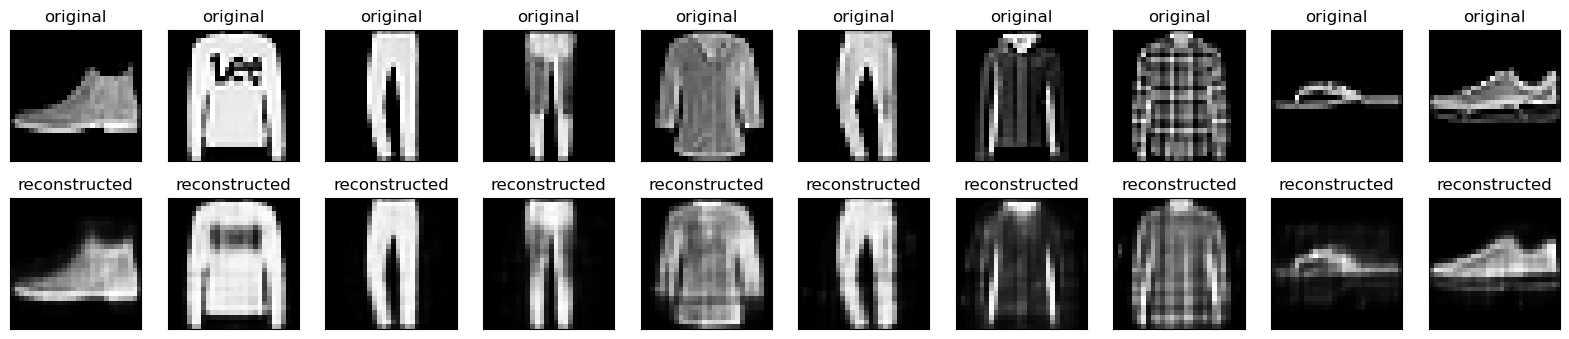

In [7]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2,n,i+n+1)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Second example: Image denoising

An autoencoder can also be trained to remove noise from images. In the following section, we will create a noisy version of of the Fashion MNIST dataset by applying random noise to each image. We will then train an autoencoder using the noisy image as input, and the original image as the target.

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.

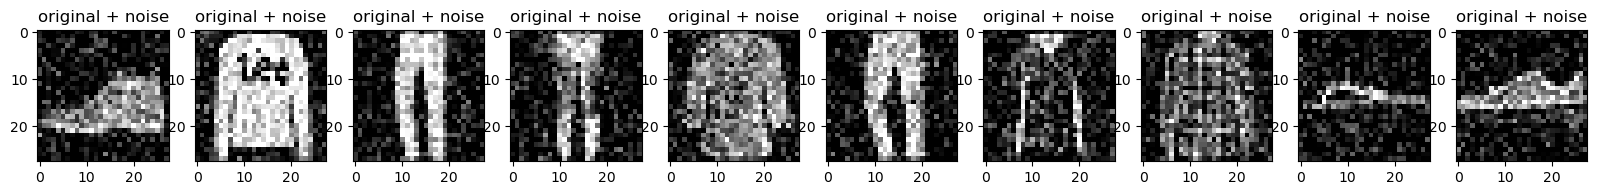

In [11]:
n = 10 
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

#### Define a convolutional autoencoder 

Again we will use the subclassing API

In [12]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0181 - val_loss: 0.0090
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/10
1875/1875 [==============================] - 15s 8ms/step - l

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

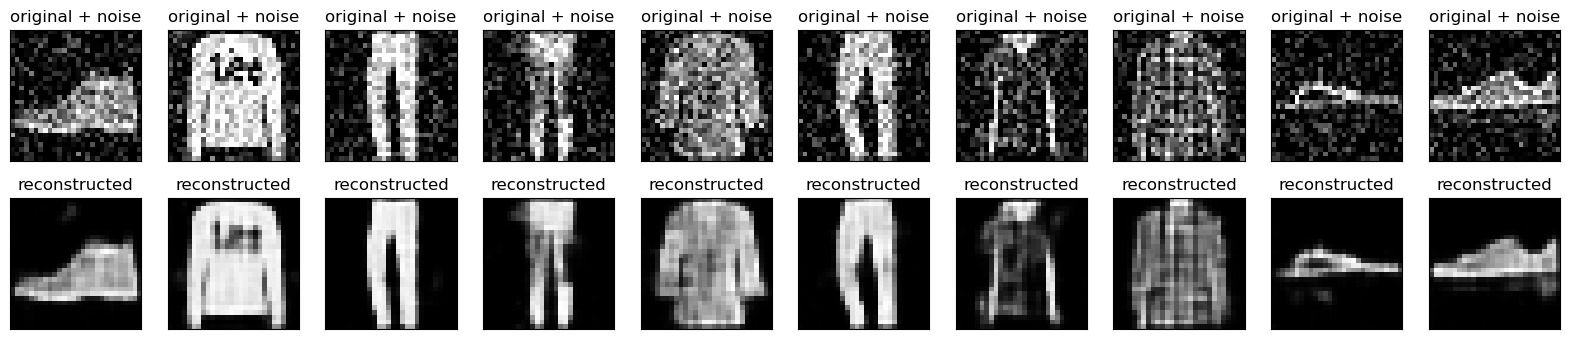

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

### Third example: Anomaly Detection

Load ECG data

In [19]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


The last element in this data contains the labels, while the rest of the data points are the electrocardiogram data.

In [20]:
labels = raw_data[:, -1]

data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to [0, 1]

In [21]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

The autoencoder will be trained using only normal rhythm data, labeled as in the labels element `1`. Let's separate all data associated with normal rhythms for training. 

In [22]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anamolous_train_data = train_data[~train_labels]
anamolous_test_data = test_data[~test_labels]

Plot normal ECG

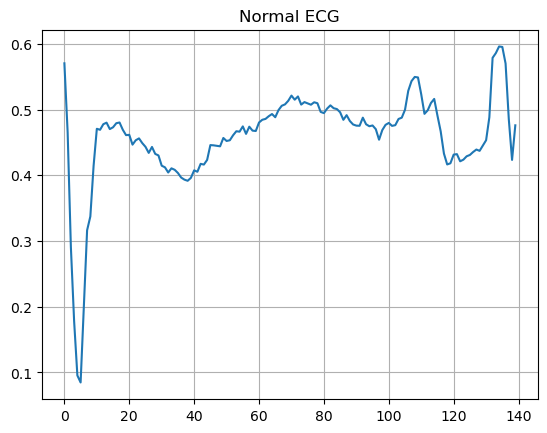

In [23]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("Normal ECG")
plt.show()

Plot an Anomalous ECG

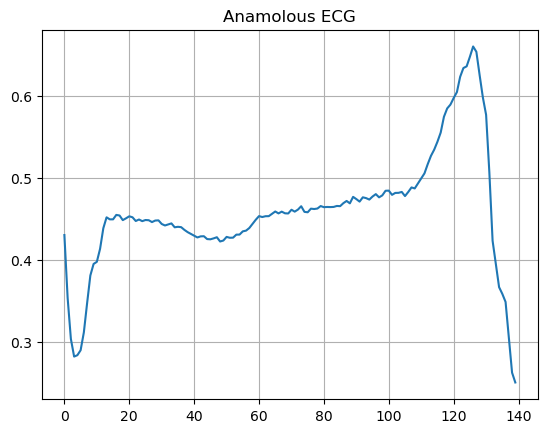

In [24]:
plt.grid()
plt.plot(np.arange(140), anamolous_train_data[0])
plt.title("Anamolous ECG")
plt.show()

### Build the Anomaly Detection model

In [25]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()


In [26]:
autoencoder.compile(optimizer='adam', loss='mae')

In [27]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                        epochs=20,
                        batch_size=512,
                        validation_data=(test_data, test_data),
                        shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0582 - val_loss: 0.0534
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0564 - val_loss: 0.0520
Epoch 3/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0541 - val_loss: 0.0502
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0507 - val_loss: 0.0486
Epoch 5/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0466 - val_loss: 0.0469
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0428 - val_loss: 0.0445
Epoch 7/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0395 - val_loss: 0.0429
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0366 - val_loss: 0.0418
Epoch 9/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0340 - val_loss: 0.0405
Epoch 10/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0319 - val_loss: 0.0397
Epoch 11/20
5/5 [=====================

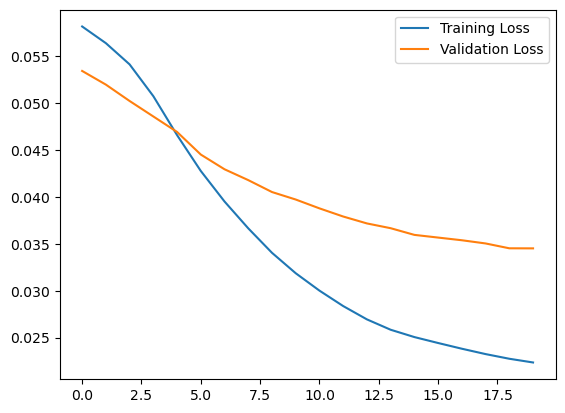

In [28]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()

Now that we have this model trained and tested we can determine what the model classifies as anamomalous data if the autoencoder reconstruction is greater than one standard deviation from the normal training data.

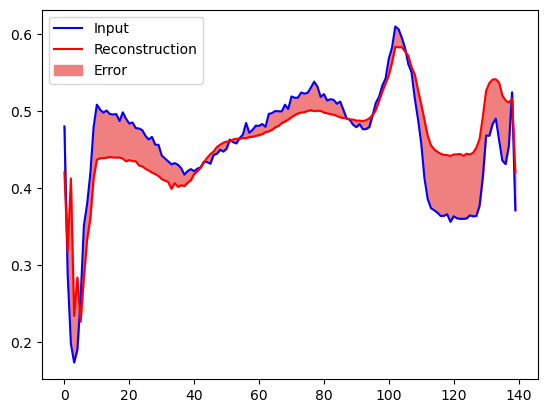

In [29]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect Anomalies
Anomalies will be detetcted by calculating whether the reconstruction loss is greater than a fixed throshold.

Here, I calculate the mean average error for normal examples from the training set, then classify other examples as anamolous if the reconstruction error is higher than one standard deviation from the training set.

First lets plot reconstruction error of the normal ECGs from the training set.

74/74 [==============================] - 0s 329us/step


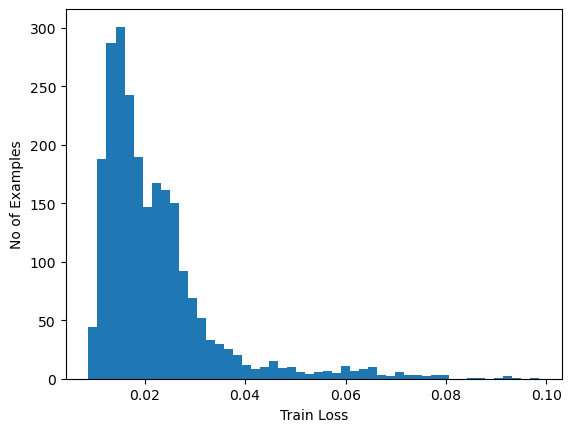

In [30]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train Loss")
plt.ylabel("No of Examples")
plt.show()

Choose threshold value that is one standard deviation above the mean

In [31]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033937763


14/14 [==============================] - 0s 622us/step


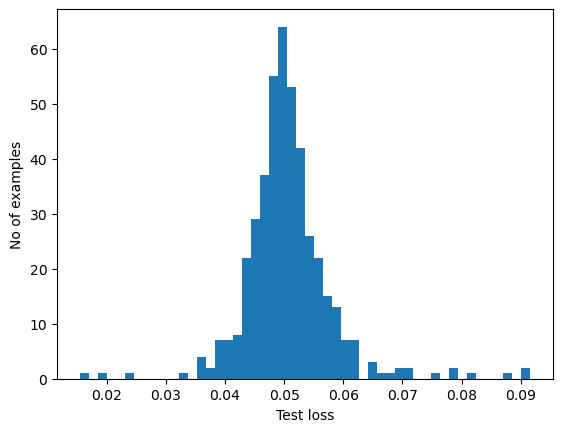

In [32]:
reconstructions = autoencoder.predict(anamolous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anamolous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Most of the examples in the anomalous test data set have a reconstruction loss greater than one standard deviation above the normal training average. Suggesting that this is a proper threshold to maintain.

Now it is time to classify an ECG as anomalous are not if the reconstracution loss is greater than the threshold.

In [33]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [34]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714
